In [1]:
!git clone https://github.com/kushalvyas/alpine.git
%cd alpine
!pip3 install -e .

Cloning into 'alpine'...
remote: Enumerating objects: 724, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 724 (delta 177), reused 239 (delta 137), pack-reused 416 (from 1)
Receiving objects: 100% (724/724), 10.82 MiB | 18.31 MiB/s, done.
Resolving deltas: 100% (361/361), done.
/content/alpine
Obtaining file:///content/alpine
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.6 MB/s eta 0

In [2]:
import torch
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics import MetricTracker

from matplotlib import pyplot as plt
from tqdm import tqdm
import skimage.transform

import alpine
from alpine.models import Finer
from alpine.metrics import SSIM
from alpine.models.utils import get_coords_spatial



/content/alpine/alpine/models/siren.py:63: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the number of input features.
/content/alpine/alpine/models/strainer.py:74: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the number of input features.
/content/alpine/alpine/models/wire.py:69: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the number of input features.
/content/alpine/alpine/models/ffn.py:81: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the number

Using device: cuda


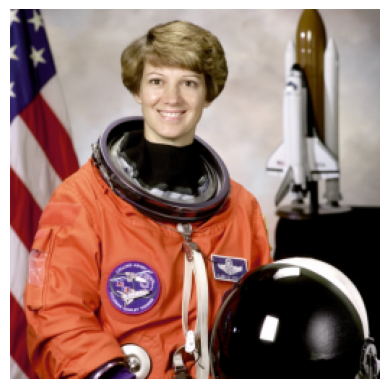

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

img_res = (256, 256) # Image resolution

gt_img = skimage.transform.resize(skimage.data.astronaut(), img_res)
gt = torch.from_numpy(gt_img).float().to(device)

image_cpu = gt.cpu().numpy()
plt.imshow(image_cpu)
plt.axis('off')
plt.show()


In [6]:
coords = get_coords_spatial(img_res[0], img_res[1]).to(device)[None, ...]
print(f"Coordinates shape: {coords.shape}")

Coordinates shape: torch.Size([1, 256, 256, 2])


In [7]:
finer_model = Finer(in_features=2, out_features=3, hidden_features=256, hidden_layers=3).to(device)
print(finer_model)
finer_model.compile()

Finer(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (model): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): FinerSine()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): FinerSine()
    (4): Linear(in_features=256, out_features=3, bias=False)
  )
)


In [8]:
epochs = 5000

In [9]:
outputs = finer_model.fit_signal(input=coords, signal=gt, n_iters=epochs, enable_tqdm=True, return_features=True, 
                                    metric_trackers = {'psnr': MetricTracker(PeakSignalNoiseRatio(data_range=1.0).to(device)), 
                                                       'ssim' : MetricTracker(alpine.metrics.SSIM(signal_shape=img_res).to(device))
                                                       }, 
                                    track_loss_history=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([256, 256, 3])) that is different to the input size (torch.Size([1, 256, 256, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


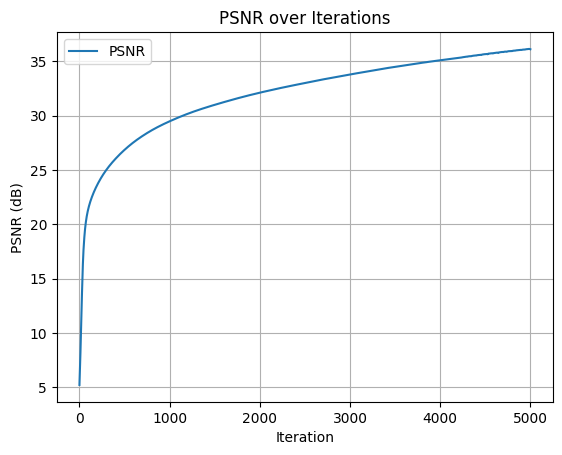

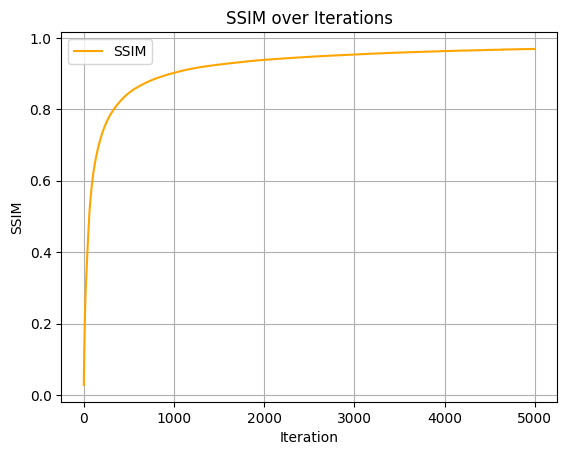

In [11]:
output = outputs['output']
all_metrics = outputs['metrics']

# Plot psnr
plt.plot(all_metrics['psnr'], label='PSNR')
plt.xlabel('Iteration')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations')
plt.legend()
plt.grid()
plt.show()

# Plot ssim
plt.plot(all_metrics['ssim'], label='SSIM', color='orange')
plt.xlabel('Iteration')
plt.ylabel('SSIM')
plt.title('SSIM over Iterations')
plt.legend()
plt.grid()
plt.show()

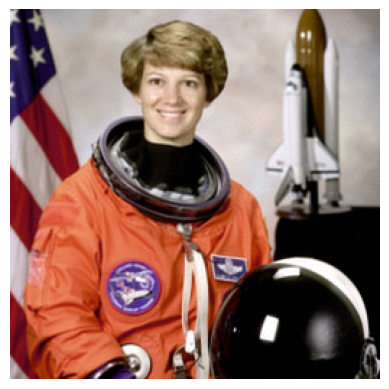

In [12]:

plt.figure()
plt.imshow(output.cpu().detach().numpy().reshape(256,256,3).clip(0,1))
plt.axis('off')
plt.show()